# Hagen Kahng EIG Partitioning

## For two partitions P1 and P2

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig as eigen

class Graph:
    def __init__(self):
        self.adj_list = []
        self.nodes = []
        self.num_nodes = 0
        self.node_affiliation = {}
        self.cxy = {}
    
    def addNode(self, node, affiliation):
        self.num_nodes += 1
        self.nodes.append(node)
        self.node_affiliation[node] = affiliation

    def addEdge(self, a, b, w):
        if(a in self.nodes and b in self.nodes):
            t, l = (min(a,b), max(a,b))
            for i in range(len(self.adj_list)):
                if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                    self.adj_list[i][2] += w
                    self.cxy[t+l] = self.adj_list[i][2]
                    return
            self.adj_list.append([t, l, w])
            self.cxy[t+l] = w
        else:
            print("This node is not declared")
    
    def get_cost(self):
        cost = 0
        d = self.node_affiliation
        for i in self.adj_list:
            if(d[i[0]] != d[i[1]]):
                cost += i[2]
        return cost

    def IE(self, node):
        #(internal, external) cost of nodes
        internal, external = 0, 0
        d = self.node_affiliation
        p = d[node]
        for i in self.adj_list:
            if(i[0] == node):
                if(d[i[1]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            elif(i[1] == node):
                if(d[i[0]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            else:
                pass
        return (internal, external)

class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        self.graph = graph
        for i in graph.nodes:
            self.G.add_node(i)
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        nodes = self.graph.nodes
        p1 = [i for i in nodes if self.graph.node_affiliation[i] == 'p1']
        colors = ['red' if n in p1 else 'green' for n in list(self.G.nodes)]
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, node_color = colors)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        plt.show()

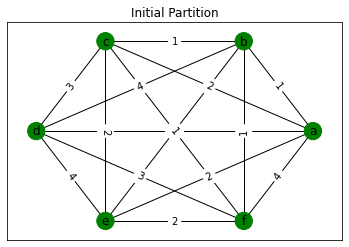

In [2]:
from networkx.algorithms.community.centrality import girvan_newman

graph = Graph()

# equitable distribution

graph.addNode('a','p2')
graph.addNode('b','p2')
graph.addNode('c','p2')
graph.addNode('d','p2')
graph.addNode('e','p2')
graph.addNode('f','p2')

graph.addEdge('a','f', 4)
graph.addEdge('a','e', 2)
graph.addEdge('a','d', 3)
graph.addEdge('a','b', 1)
graph.addEdge('a','c', 2)
graph.addEdge('b','c', 1)
graph.addEdge('b','d', 4)
graph.addEdge('b','e', 2)
graph.addEdge('b','f', 1)
graph.addEdge('c','d', 3)
graph.addEdge('c','e', 2)
graph.addEdge('c','f', 1)
graph.addEdge('d','e', 4)
graph.addEdge('d','f', 3)
graph.addEdge('e','f', 2)

gv = GraphVisualizer()
gv.addEdges(graph)
gv.visualize("Initial Partition")

In [3]:
def find_min(vector, used):
    min_value = 1
    min_i = 0
    for i, value in enumerate(vector):
        if (i not in used and value < min_value):
            min_value = value
            min_i = i
    return min_i

def eig(graph):
    nodes = graph.nodes
    lst = graph.adj_list
    Adj = np.zeros( (len(nodes), len(nodes)) )
    Deg = np.zeros( (len(nodes), len(nodes)) )
    
    I, E, D = {},{},{}
    for i, node in enumerate(nodes):
        I[node],E[node] = graph.IE(node)
        Deg[i][i] = I[node] + E[node]
    print("The Degree Matrix is \n", Deg, "\n")
    
    for adj in lst:
        for i, node in enumerate(nodes):
            for j, node2 in enumerate(nodes):
                if ((node == adj[0]) and (node2 == adj[1])):
                    Adj[i][j] = adj[2]
                    Adj[j][i] = adj[2]
    print("The Adjacency Matrix is \n", Adj, "\n")
    
    Lap = Deg - Adj
    print("The Laplacian Matrix is \n", Lap, "\n")
    
    w,v=eigen(Lap)
    #print(w,v)
    
    second_min = 1000;
    second_mini = 0;
    for i, value in enumerate(w):
        if (value != min(w) and value < second_min):
            second_min = value
            second_mini = i
    vector = v[second_mini]
    print("Second smallest eigenvalue is", second_min)
    print("Corresponding eigenvector is \n", vector, "\n")
    
    used = []
    for i in range(len(nodes)-1):
        min_i = find_min(vector, used)
        used.append(min_i)
        min_node = nodes[min_i]
        graph.node_affiliation[min_node] = 'p1'
        print(graph.node_affiliation)
        rc = graph.get_cost()/((i+1)*(len(nodes)-i-1))
        print("Cutsize", graph.get_cost())
        print("Ratio Cut", rc, "\n")

In [4]:
eig(graph)

The Degree Matrix is 
 [[12.  0.  0.  0.  0.  0.]
 [ 0.  9.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  0.  0.]
 [ 0.  0.  0. 17.  0.  0.]
 [ 0.  0.  0.  0. 12.  0.]
 [ 0.  0.  0.  0.  0. 11.]] 

The Adjacency Matrix is 
 [[0. 1. 2. 3. 2. 4.]
 [1. 0. 1. 4. 2. 1.]
 [2. 1. 0. 3. 2. 1.]
 [3. 4. 3. 0. 4. 3.]
 [2. 2. 2. 4. 0. 2.]
 [4. 1. 1. 3. 2. 0.]] 

The Laplacian Matrix is 
 [[12. -1. -2. -3. -2. -4.]
 [-1.  9. -1. -4. -2. -1.]
 [-2. -1.  9. -3. -2. -1.]
 [-3. -4. -3. 17. -4. -3.]
 [-2. -2. -2. -4. 12. -2.]
 [-4. -1. -1. -3. -2. 11.]] 

Second smallest eigenvalue is 9.650174361156632
Corresponding eigenvector is 
 [-4.08248290e-01 -2.75727153e-01 -1.06601407e-15 -8.69378352e-01
 -3.85895230e-02 -7.30632199e-17] 

{'a': 'p2', 'b': 'p2', 'c': 'p2', 'd': 'p1', 'e': 'p2', 'f': 'p2'}
Cutsize 17
Ratio Cut 3.4 

{'a': 'p1', 'b': 'p2', 'c': 'p2', 'd': 'p1', 'e': 'p2', 'f': 'p2'}
Cutsize 23
Ratio Cut 2.875 

{'a': 'p1', 'b': 'p1', 'c': 'p2', 'd': 'p1', 'e': 'p2', 'f': 'p2'}
Cutsize 22
Ratio Cut 2.444444

### We get minimum ratio cut for the last partitioning

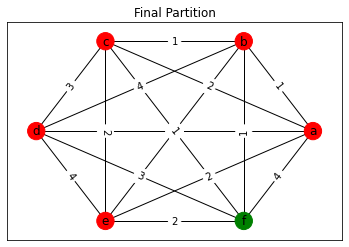

The wire cost of partitioning is 11


In [5]:
gv = GraphVisualizer()
gv.addEdges(graph)
gv.visualize("Final Partition")

print("The wire cost of partitioning is", graph.get_cost())